In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
SEED = 12
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [2]:
# import pandas as pd

# # 기존 데이터 경로
# data_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Final_1h_No Missing.csv"

# # 새로 포함할 Feature 목록
# selected_features = ['inner_temperature', 'outside_temperature', 'wind_speed', 'timestamp', 'cooling_power']

# # 데이터 로드
# df = pd.read_csv(data_path)

# # 선택된 Feature만 포함
# df_selected = df[selected_features]

# # 새로운 파일 저장 경로
# output_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Selected_Features.csv"
# df_selected.to_csv(output_path, index=False)

# output_path


In [3]:
data_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Rank_based_feature.csv"


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 데이터 경로 설정
data_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Rank_based_feature.csv"

def load_data(path=data_path):
    """Loads the dataset, drops 'timestamp', and splits into X (features) and Y (target)."""
    df = pd.read_csv(path)
    df = df.drop(columns=['timestamp'])  # 'timestamp' 제거
    X = df.drop(columns=['cooling_power'])  # 입력 변수
    Y = df[['cooling_power']]  # 타겟 변수
    return X, Y



def split_data(X, Y, train_fraq, test_len=108):
    """Splits input X and target Y into train, val, and test sets."""
    if test_len > len(X):
        raise ValueError("test_len cannot be greater than the total number of samples.")
    
    test_slice = len(X) - test_len

    X_test, Y_test = X[test_slice:], Y[test_slice:]
    X_train_val, Y_train_val = X[:test_slice], Y[:test_slice]

    train_size = int(len(X_train_val) * train_fraq)

    X_train, Y_train = X_train_val[:train_size], Y_train_val[:train_size]
    X_val, Y_val = X_train_val[train_size:], Y_train_val[train_size:]

    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)


def min_max_scale(train_X, train_Y, val_X, val_Y, test_X, test_Y):
    """Applies MinMax Scaling using only the Train data for fitting."""
    mm_X = MinMaxScaler()
    mm_Y = MinMaxScaler()

    # Fit on Train data only
    train_X_scaled = mm_X.fit_transform(train_X)
    train_Y_scaled = mm_Y.fit_transform(train_Y)

    # Transform Validation and Test data
    val_X_scaled = mm_X.transform(val_X)
    val_Y_scaled = mm_Y.transform(val_Y)
    test_X_scaled = mm_X.transform(test_X)
    test_Y_scaled = mm_Y.transform(test_Y)

    return (train_X_scaled, train_Y_scaled), (val_X_scaled, val_Y_scaled), (test_X_scaled, test_Y_scaled), mm_X, mm_Y


def window_dataset(X, Y, n_steps, n_horizon, batch_size, shuffle_buffer, for_training=True):
    """
    Creates a windowed TensorFlow dataset.
    
    Parameters:
    - X: Input features
    - Y: Target values
    - n_steps: Number of timesteps in input
    - n_horizon: Prediction horizon
    - batch_size: Batch size for the dataset
    - shuffle_buffer: Buffer size for shuffling (applies only for training)
    - for_training: If True, applies shuffling for training data
    
    Returns:
    - A TensorFlow dataset object.
    """
    # Sliding window generation
    ds_X = tf.data.Dataset.from_tensor_slices(X)
    ds_Y = tf.data.Dataset.from_tensor_slices(Y)

    # Apply window
    ds_X = ds_X.window(n_steps, shift=n_horizon, drop_remainder=True).flat_map(lambda x: x.batch(n_steps))
    ds_Y = ds_Y.window(n_horizon, shift=n_horizon, drop_remainder=True).flat_map(lambda x: x.batch(n_horizon))

    # Combine inputs and targets
    ds = tf.data.Dataset.zip((ds_X, ds_Y))

    # Apply shuffle only for training data
    if for_training:
        ds = ds.shuffle(shuffle_buffer)

    # Batch and prefetch
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [5]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    """Creates an LSTM model for predicting a single target variable."""

    # Clear any previous session
    tf.keras.backend.clear_session()

    # Build the model
    model = tf.keras.models.Sequential([
        # First LSTM Layer
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        
        # Second LSTM Layer
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        
        # Dense Layers for Prediction
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),  # Dropout for regularization
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),  # Additional Dropout Layer
        
        # Output Layer (single value for n_horizon=1)
        tf.keras.layers.Dense(n_horizon)  # n_horizon=1 for single step prediction
    ], name='lstm')

    # Define loss and optimizer
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

    return model


In [6]:
X, Y = load_data()

# 데이터 분리
(train_X, train_Y), (val_X, val_Y), (test_X, test_Y) = split_data(X, Y, train_fraq=0.82, test_len=651)

# MinMax Scaling
(train_X_scaled, train_Y_scaled), (val_X_scaled, val_Y_scaled), (test_X_scaled, test_Y_scaled), mm_X, mm_Y = min_max_scale(
    train_X, train_Y, val_X, val_Y, test_X, test_Y
)

# TensorFlow Dataset 생성
train_ds = window_dataset(train_X_scaled, train_Y_scaled, n_steps=12, n_horizon=1, batch_size=32, shuffle_buffer=100, for_training=True)
val_ds = window_dataset(val_X_scaled, val_Y_scaled, n_steps=12, n_horizon=1, batch_size=32, shuffle_buffer=0, for_training=False)
test_ds = window_dataset(test_X_scaled, test_Y_scaled, n_steps=12, n_horizon=1, batch_size=32, shuffle_buffer=0, for_training=False)

In [7]:
# 스케일링 확인
print("Original train_Y range:", train_Y.min(), train_Y.max())
print("Scaled train_Y range:", train_Y_scaled.min(), train_Y_scaled.max())

# 복원 확인
train_Y_restored = mm_Y.inverse_transform(train_Y_scaled)
print("Restored train_Y range:", train_Y_restored.min(), train_Y_restored.max())


Original train_Y range: cooling_power    0.0
dtype: float64 cooling_power    43.81415
dtype: float64
Scaled train_Y range: 0.0 1.0
Restored train_Y range: 0.0 43.81415


In [8]:
print("Original train_X range:", train_X.min(), train_X.max())
print("Scaled train_X range:", train_X_scaled.min(), train_X_scaled.max())

# 복원 확인
train_X_restored = mm_X.inverse_transform(train_X_scaled)
print("Restored train_X range:", train_X_restored.min(), train_X_restored.max())


Original train_X range: inner_temperature      16.24750
Temp_Difference       -18.24500
inner_humidity         31.21667
Humidity_Difference   -40.06000
outside_temperature    26.91000
dtype: float64 inner_temperature      37.16417
Temp_Difference         3.96250
inner_humidity         82.91667
Humidity_Difference    35.87667
outside_temperature    38.78000
dtype: float64
Scaled train_X range: 0.0 1.0
Restored train_X range: -40.06 82.91667


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',       # Validation Loss를 모니터링
    patience=30,              # 개선되지 않는 에포크 수 (5번 기다림)
    restore_best_weights=True # 가장 낮은 Validation Loss에서의 가중치 복원
)


In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# # ReduceLROnPlateau 설정
lr_decay = ReduceLROnPlateau(
    monitor='val_loss',       # Validation Loss를 기준으로 Learning Rate 감소
    factor=0.5,               # Learning Rate를 50%로 줄임
    patience=15,               # 개선되지 않는 에포크 수 (5번 기다림)
    min_lr=1e-5               # Learning Rate의 하한값
)


In [11]:
model_checkpoint = ModelCheckpoint(
    filepath='best_lstm_rank.keras',  # 저장 경로
    monitor='val_loss',       # 모니터링할 값
    save_best_only=True,      # Best 모델만 저장
    verbose=1
)

In [12]:
# LSTM 모델 생성
lstm = lstm_model(n_steps=12, n_horizon=1, n_features=train_X_scaled.shape[1], lr=3e-4)

# EarlyStopping 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Learning Rate Decay 콜백
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5)

# 모델 학습
history = lstm.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    callbacks=[early_stopping, lr_decay, model_checkpoint]  # 콜백 추가
)

# # 테스트 결과 출력
# lstm.evaluate(test_ds)


Epoch 1/300


     91/Unknown - 2s 4ms/step - loss: 0.0367 - mae: 0.2156
Epoch 1: val_loss improved from inf to 0.00165, saving model to best_lstm_rank.keras
95/95 [==============================] - 2s 8ms/step - loss: 0.0355 - mae: 0.2101 - val_loss: 0.0016 - val_mae: 0.0485 - lr: 3.0000e-04
Epoch 2/300
89/95 [===========================>..] - ETA: 0s - loss: 0.0124 - mae: 0.1168
Epoch 2: val_loss improved from 0.00165 to 0.00123, saving model to best_lstm_rank.keras
95/95 [==============================] - 0s 5ms/step - loss: 0.0118 - mae: 0.1126 - val_loss: 0.0012 - val_mae: 0.0389 - lr: 3.0000e-04
Epoch 3/300
92/95 [============================>.] - ETA: 0s - loss: 0.0111 - mae: 0.1108
Epoch 3: val_loss improved from 0.00123 to 0.00088, saving model to best_lstm_rank.keras
95/95 [==============================] - 0s 5ms/step - loss: 0.0109 - mae: 0.1091 - val_loss: 8.8301e-04 - val_mae: 0.0312 - lr: 3.0000e-04
Epoch 4/300
83/95 [=========================>....] - ETA: 0s - loss: 0.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model

# 모델 요약 출력
lstm.summary()

# 모델 구조 시각화
plot_model(lstm, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 72)            22464     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129    

In [14]:
# !dot -V

In [15]:
# !pip install graphviz

In [16]:
# import tensorflow as tf

# # GPU 사용 가능한지 확인
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     print(f"사용 가능한 GPU: {gpus}")
# else:
#     print("GPU를 찾을 수 없습니다. CPU를 사용합니다.")

In [17]:
# !pip uninstall tensorflow
# !pip install tensorflow


In [18]:
# !pip install tensorflow-gpu==2.6.0

In [19]:
# !nvcc --version  # CUDA Toolkit 버전 확인


In [20]:
# 테스트 데이터셋에서 예측 수행
y_pred_scaled = lstm.predict(test_ds)  # (samples, n_horizon) 형태

# y_pred를 (samples, 1)로 변환
y_pred = y_pred_scaled.reshape(-1, 1)  # 2차원으로 변환

# y_pred의 스케일 복원
y_pred = mm_Y.inverse_transform(y_pred)

# y_true를 TensorFlow Dataset에서 추출 및 스케일 복원
y_true_scaled = np.concatenate([y for x, y in test_ds], axis=0)  # (samples, n_horizon)
y_true = y_true_scaled.reshape(-1, 1)  # 2차원으로 변환
y_true = mm_Y.inverse_transform(y_true)


20/20 [==============================] - 0s 3ms/step


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 성능 결과 출력
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 1.09
RMSE: 1.37
MAPE: 9.44%


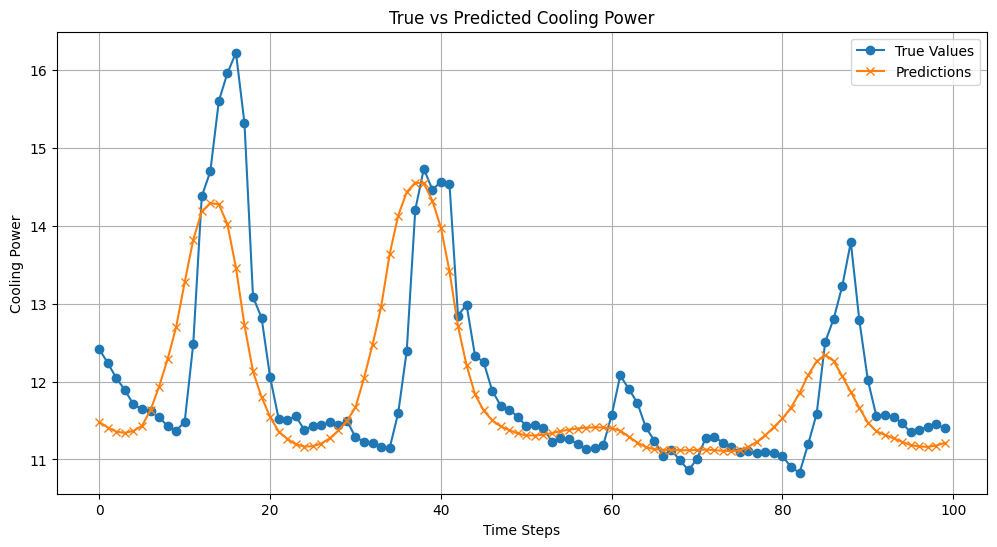

In [22]:
import matplotlib.pyplot as plt

# 샘플 수 선택 (테스트 데이터 일부만 시각화)

plt.figure(figsize=(12, 6))

plt.plot(y_true[:100], label="True Values", marker='o')
plt.plot(y_pred[:100], label="Predictions", marker='x')

plt.title("True vs Predicted Cooling Power")
plt.xlabel("Time Steps")
plt.ylabel("Cooling Power")
plt.legend()
plt.grid()
plt.show()


In [23]:
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim):
        super().__init__()
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
        positions = self.pos_embedding(positions)
        return inputs + positions


In [24]:
def transformer_model(n_steps, n_horizon, n_features, lr):
    """Creates an optimized Transformer model for time series forecasting."""

    # Clear any previous session
    tf.keras.backend.clear_session()

    # Input Layer
    inputs = tf.keras.layers.Input(shape=(n_steps, n_features))

    # Position Embedding
    position_embedding = PositionEmbedding(max_len=n_steps, embed_dim=n_features)(inputs)

    # Transformer Encoder
    transformer = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(position_embedding, position_embedding)
    transformer = tf.keras.layers.LayerNormalization(epsilon=1e-6)(transformer)
    transformer = tf.keras.layers.Dropout(0.1)(transformer)

    # Feed-Forward Network
    ff = tf.keras.layers.Dense(128, activation="relu")(transformer)
    ff = tf.keras.layers.Dropout(0.1)(ff)
    ff = tf.keras.layers.Dense(64, activation="relu")(ff)
    ff = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff)

    # Global Average Pooling
    pooled = tf.keras.layers.GlobalAveragePooling1D()(ff)

    # Output Layer
    outputs = tf.keras.layers.Dense(n_horizon)(pooled)

    # Build Model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="transformer")

    # Custom Learning Rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )

    # Compile Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss="mse",
                  metrics=["mae"])

    return model


In [25]:
# EarlyStopping 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


In [26]:
model_checkpoint = ModelCheckpoint(
    filepath='best_transformer_rank.keras',  # 저장 경로
    monitor='val_loss',       # 모니터링할 값
    save_best_only=True,      # Best 모델만 저장
    verbose=1
)

In [27]:
# LSTM 모델 생성
transformer = transformer_model(n_steps=12, n_horizon=1, n_features=train_X_scaled.shape[1], lr=3e-4)

# EarlyStopping 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Learning Rate Decay 콜백
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5)

# 모델 학습
history_transformer = transformer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=120,
    callbacks=[early_stopping, model_checkpoint]  # 콜백 추가
)

Epoch 1/120
     77/Unknown - 1s 3ms/step - loss: 0.1389 - mae: 0.2020
Epoch 1: val_loss improved from inf to 0.00898, saving model to best_transformer_rank.keras
95/95 [==============================] - 2s 6ms/step - loss: 0.1154 - mae: 0.1800 - val_loss: 0.0090 - val_mae: 0.0808
Epoch 2/120
86/95 [==========================>...] - ETA: 0s - loss: 0.0165 - mae: 0.1006
Epoch 2: val_loss did not improve from 0.00898
95/95 [==============================] - 0s 3ms/step - loss: 0.0157 - mae: 0.0977 - val_loss: 0.0095 - val_mae: 0.0722
Epoch 3/120
89/95 [===========================>..] - ETA: 0s - loss: 0.0133 - mae: 0.0908
Epoch 3: val_loss improved from 0.00898 to 0.00679, saving model to best_transformer_rank.keras
95/95 [==============================] - 0s 3ms/step - loss: 0.0130 - mae: 0.0896 - val_loss: 0.0068 - val_mae: 0.0658
Epoch 4/120
84/95 [=========================>....] - ETA: 0s - loss: 0.0133 - mae: 0.0906
Epoch 4: val_loss improved from 0.00679 to 0.00428, saving model to

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model

# 모델 요약 출력
transformer.summary()

# 모델 구조 시각화
plot_model(transformer, to_file='transformer_model.png', show_shapes=True, show_layer_names=True)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 5)]              0         []                            
                                                                                                  
 position_embedding (Positi  (None, 12, 5)                60        ['input_1[0][0]']             
 onEmbedding)                                                                                     
                                                                                                  
 multi_head_attention (Mult  (None, 12, 5)                5893      ['position_embedding[0][0]',  
 iHeadAttention)                                                     'position_embedding[0][0]']  
                                                                                        

In [29]:
# 테스트 데이터셋에서 예측 수행
y_pred_scaled = transformer.predict(test_ds)  # (samples, n_horizon) 형태

# y_pred를 (samples, 1)로 변환
y_pred = y_pred_scaled.reshape(-1, 1)  # 2차원으로 변환

# y_pred의 스케일 복원
y_pred = mm_Y.inverse_transform(y_pred)

# y_true를 TensorFlow Dataset에서 추출 및 스케일 복원
y_true_scaled = np.concatenate([y for x, y in test_ds], axis=0)  # (samples, n_horizon)
y_true = y_true_scaled.reshape(-1, 1)  # 2차원으로 변환
y_true = mm_Y.inverse_transform(y_true)


20/20 [==============================] - 0s 2ms/step


In [30]:

# 성능 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 성능 결과 출력
print(f"Transformer Results")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Transformer Results
MAE: 0.73
RMSE: 0.94
MAPE: 5.99%


In [31]:
df3 = pd.read_csv(r'C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\y_true_y_pred_results.csv')
df3.head()

,y_true,y_pred
0,12.41611,11.632585
1,12.23583,11.520741
2,12.04438,11.405965
3,11.89023,11.231335
4,11.70560,11.060847


Performance Evaluation:
Transformer Results:
MAE: 0.6683
RMSE: 0.8808
MAPE: 5.30%



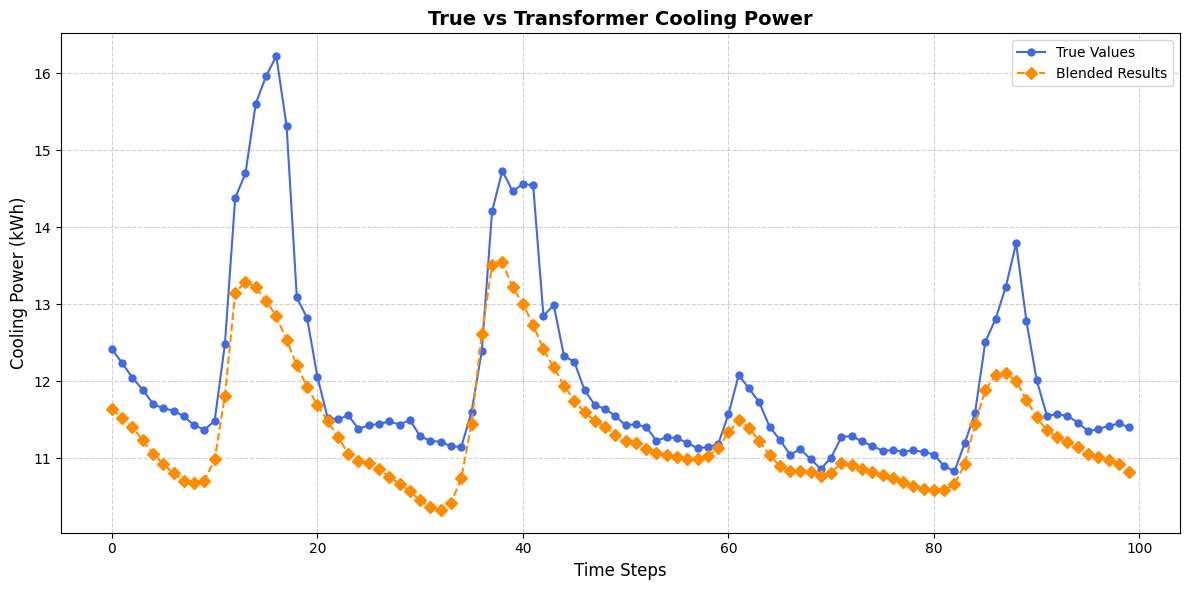

In [35]:

# 성능 평가 함수
def evaluate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{model_name} Results:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%\n")
    return mae, rmse, mape

# y_true와 각 예측값의 성능 평가
print("Performance Evaluation:")
evaluate_metrics(df3['y_true'], df3['y_pred'], "Transformer")

plt.figure(figsize=(12, 6))

plt.plot(df3['y_true'][:100], 
         label="True Values", 
         marker='o', 
         linestyle='-', 
         color='royalblue', 
         markersize=5)

# Blended Results
plt.plot(df3['y_pred'][:100], 
         label="Blended Results", 
         marker='D', 
         linestyle='--', 
         color='darkorange', 
         markersize=6)

# Plot 설정
plt.title("True vs Transformer Cooling Power", fontsize=14, fontweight='bold')
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Cooling Power (kWh)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show Plot
plt.show()

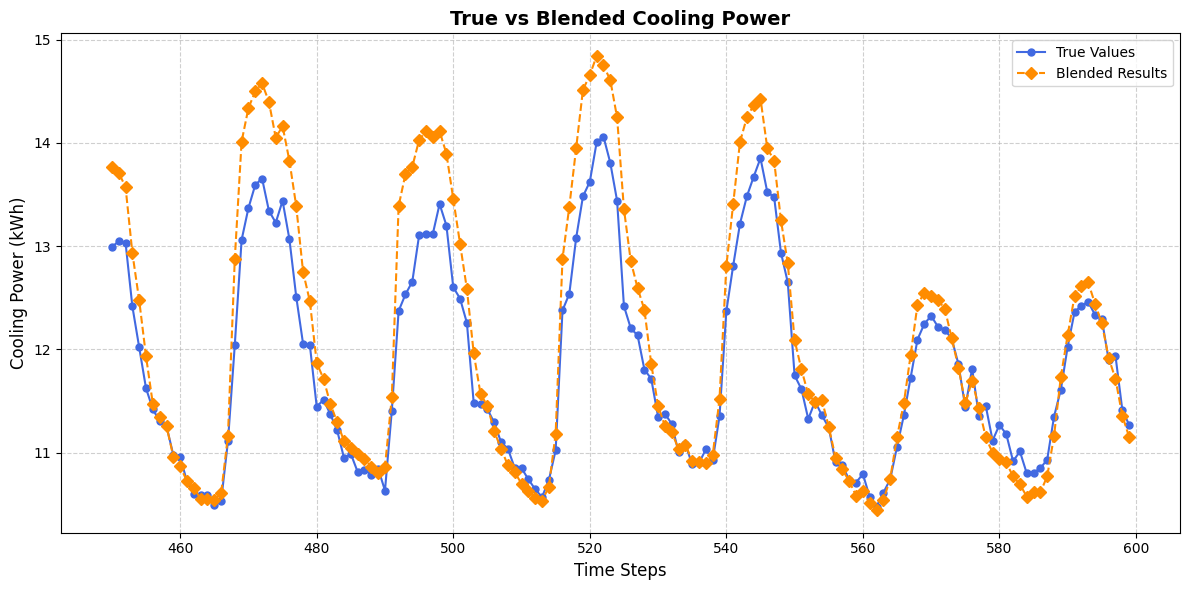

In [33]:

plt.figure(figsize=(12, 6))

plt.plot(df3['y_true'][450:600], 
         label="True Values", 
         marker='o', 
         linestyle='-', 
         color='royalblue', 
         markersize=5)

# Blended Results
plt.plot(df3['blended_result'][450:600], 
         label="Blended Results", 
         marker='D', 
         linestyle='--', 
         color='darkorange', 
         markersize=6)

# Plot 설정
plt.title("True vs Blended Cooling Power", fontsize=14, fontweight='bold')
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Cooling Power (kWh)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show Plot
plt.show()

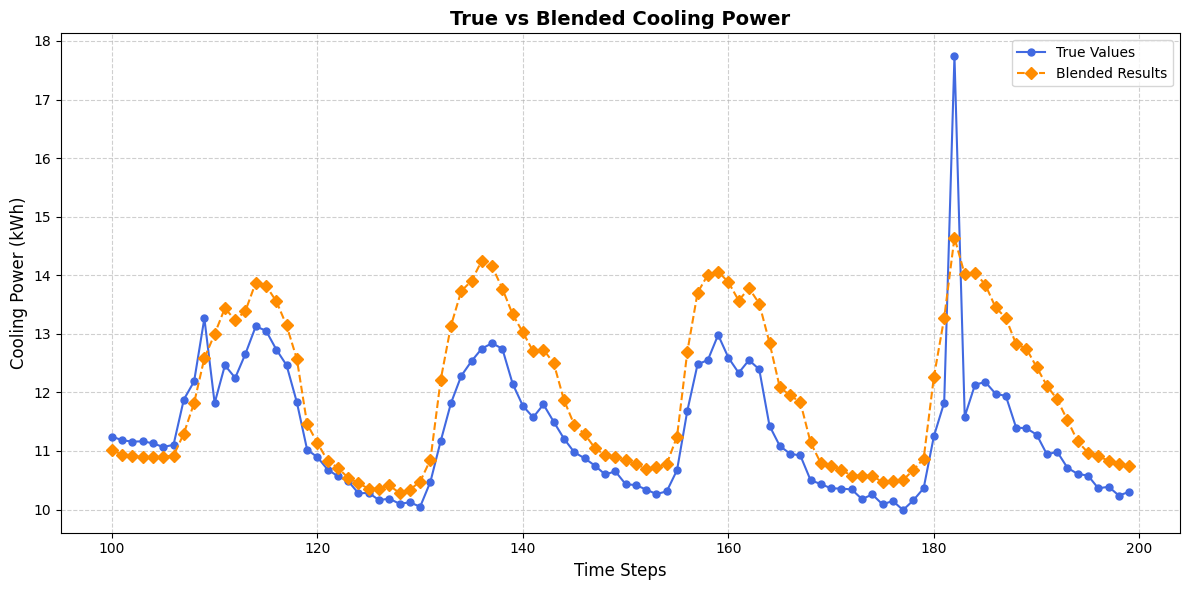

In [34]:

plt.figure(figsize=(12, 6))

plt.plot(df3['y_true'][100:200], 
         label="True Values", 
         marker='o', 
         linestyle='-', 
         color='royalblue', 
         markersize=5)

# Blended Results
plt.plot(df3['blended_result'][100:200], 
         label="Blended Results", 
         marker='D', 
         linestyle='--', 
         color='darkorange', 
         markersize=6)

# Plot 설정
plt.title("True vs Blended Cooling Power", fontsize=14, fontweight='bold')
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Cooling Power (kWh)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show Plot
plt.show()

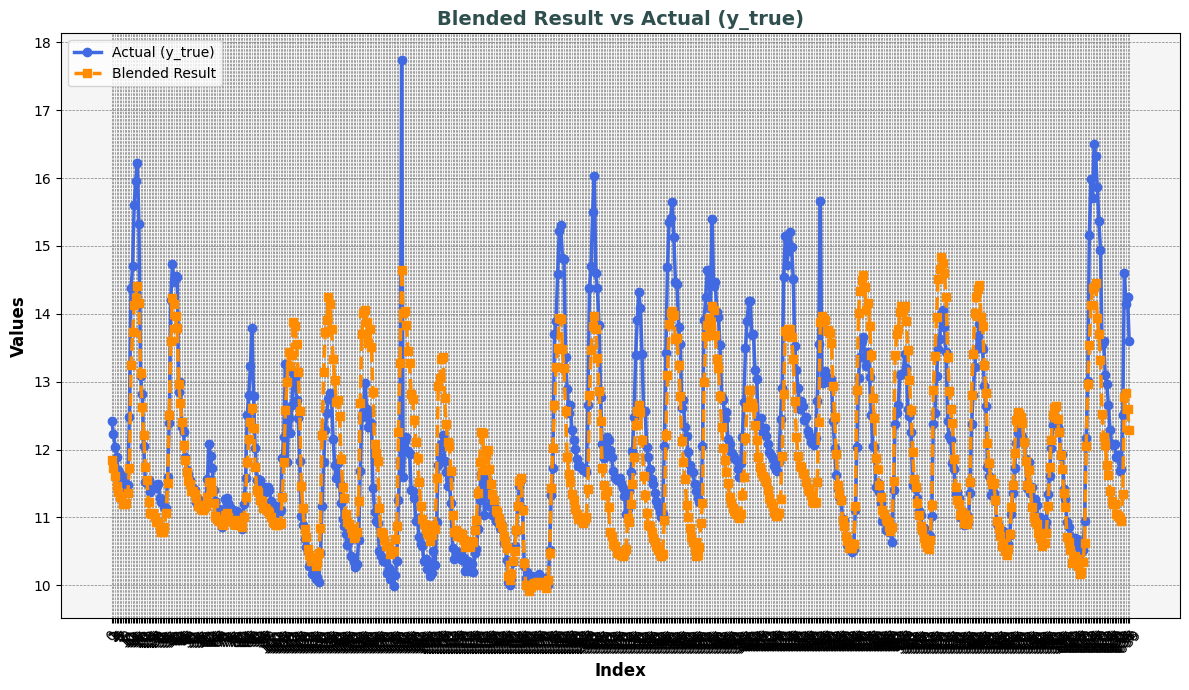

In [35]:
import matplotlib.pyplot as plt

# Plot: Blended Result vs. Actual (y_true)
plt.figure(figsize=(12, 7))  # Larger figure size for better visibility

# Actual (y_true) Line
plt.plot(df3.index, df3['y_true'], 
         label='Actual (y_true)', 
         color='royalblue', 
         linewidth=2.5, 
         marker='o', 
         markersize=6)

# Blended Result Line
plt.plot(df3.index, df3['blended_result'], 
         label='Blended Result', 
         color='darkorange', 
         linestyle='--', 
         linewidth=2.5, 
         marker='s', 
         markersize=6)

# Additional Styling
plt.xticks(df3.index, rotation=45, fontsize=10)  # Rotate and resize x-axis ticks
plt.yticks(fontsize=10)  # Resize y-axis ticks
plt.xlabel('Index', fontsize=12, fontweight='bold')
plt.ylabel('Values', fontsize=12, fontweight='bold')
plt.title('Blended Result vs Actual (y_true)', fontsize=14, fontweight='bold', color='darkslategray')
plt.legend(fontsize=10, loc='upper left', frameon=True)  # Add a legend with a frame
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Light gray grid lines
plt.tight_layout()

# Highlight background for readability
plt.gca().set_facecolor('whitesmoke')

# Show plot
plt.show()


In [36]:
y_true

array([[12.41611],
       [12.23583],
       [12.04438],
       [11.89023],
       [11.7056 ],
       [11.64632],
       [11.61929],
       [11.54202],
       [11.42865],
       [11.3698 ],
       [11.4843 ],
       [12.48276],
       [14.37966],
       [14.69821],
       [15.60497],
       [15.95934],
       [16.22289],
       [15.31763],
       [13.08724],
       [12.81987],
       [12.05767],
       [11.52234],
       [11.50517],
       [11.55613],
       [11.38101],
       [11.42796],
       [11.44388],
       [11.47855],
       [11.4361 ],
       [11.49696],
       [11.28432],
       [11.22704],
       [11.21077],
       [11.15565],
       [11.14573],
       [11.59531],
       [12.39417],
       [14.20687],
       [14.73152],
       [14.46599],
       [14.56285],
       [14.54278],
       [12.84711],
       [12.98858],
       [12.32786],
       [12.25187],
       [11.88438],
       [11.69158],
       [11.63938],
       [11.54733],
       [11.42732],
       [11.43928],
       [11.4

In [37]:
y_true = y_true.ravel()
y_pred = y_pred.ravel()

results_df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred
})

# 데이터프레임 확인
print("\nGenerated DataFrame:")
print(results_df)

# CSV 파일로 저장
output_path = 'y_true_y_pred_results.csv'
results_df.to_csv(output_path, index=False)
print(f"Results have been saved to '{output_path}'")


Generated DataFrame:
       y_true     y_pred
0    12.41611  11.632585
1    12.23583  11.520741
2    12.04438  11.405965
3    11.89023  11.231335
4    11.70560  11.060847
..        ...        ...
635  12.50182  11.686749
636  14.60105  12.437364
637  14.14145  12.269442
638  14.24521  12.039571
639  13.59895  11.795805

[640 rows x 2 columns]
Results have been saved to 'y_true_y_pred_results.csv'


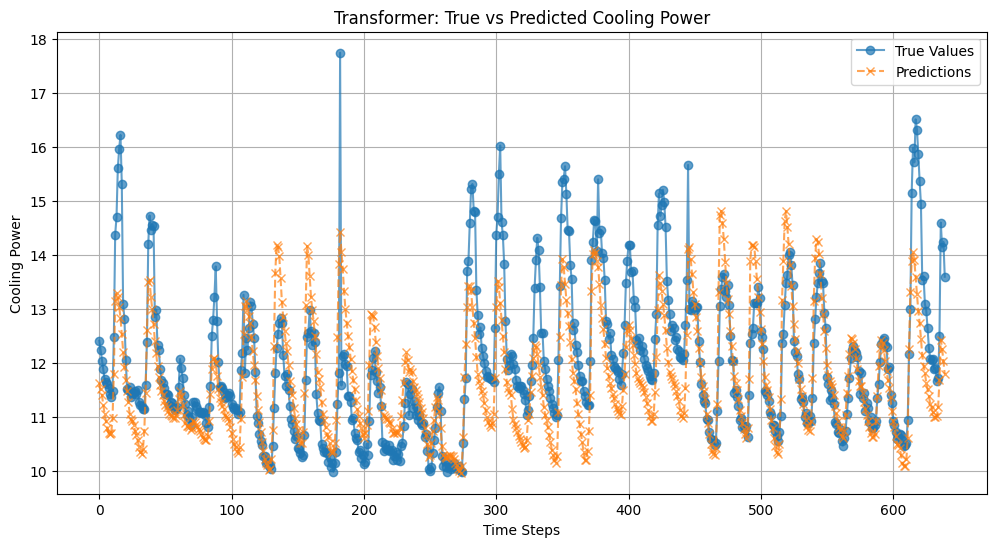

In [38]:

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 샘플 수 선택 (테스트 데이터 일부만 시각화)
plt.plot(y_true, label="True Values", marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred, label="Predictions", marker='x', linestyle='--', alpha=0.7)

plt.title("Transformer: True vs Predicted Cooling Power")
plt.xlabel("Time Steps")
plt.ylabel("Cooling Power")
plt.legend()
plt.grid()
plt.show()


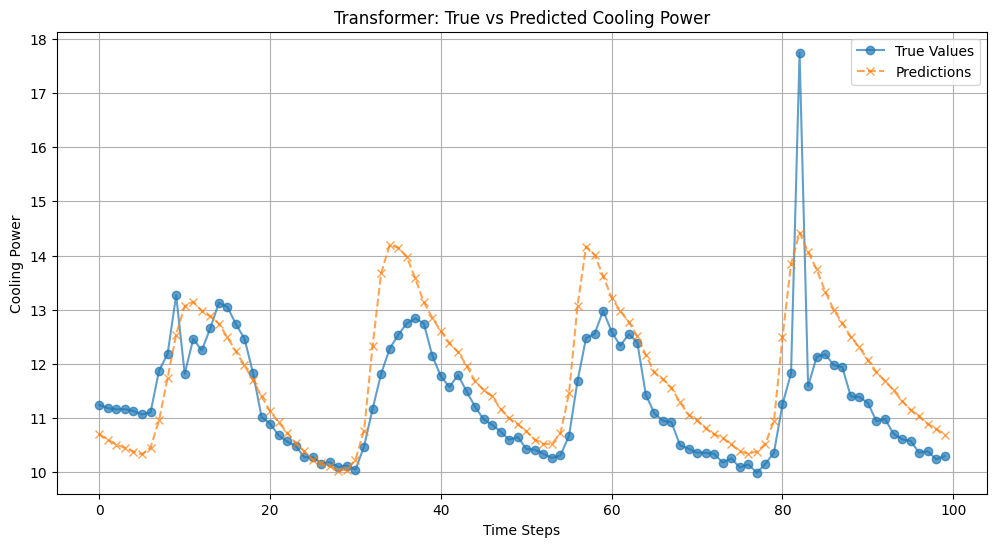

In [39]:

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 샘플 수 선택 (테스트 데이터 일부만 시각화)
plt.plot(y_true[100:200], label="True Values", marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred[100:200], label="Predictions", marker='x', linestyle='--', alpha=0.7)

plt.title("Transformer: True vs Predicted Cooling Power")
plt.xlabel("Time Steps")
plt.ylabel("Cooling Power")
plt.legend()
plt.grid()
plt.show()


In [40]:
#### 예측 

In [289]:
import pandas as pd
import numpy as np

# 새로운 데이터셋 경로 설정
new_data_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Predict_final_test_dalat.csv"

# 새로운 데이터셋 로드
def load_new_data_with_timestamp(path=new_data_path):
    """
    Loads the new dataset and retains the 'timestamp' column for final result.
    """
    df = pd.read_csv(path)
    return df

# 새로운 데이터셋 로드
new_data = load_new_data_with_timestamp()

# 'timestamp' 컬럼을 datetime 형식으로 변환
new_data['timestamp'] = pd.to_datetime(new_data['timestamp'])

# 입력 데이터(X)와 타겟 데이터(Y) 분리
X_new = new_data.drop(columns=['timestamp', 'cooling_power'])
Y_new = new_data[['cooling_power']]

# MinMax Scaling 적용 (기존 모델의 Scaler 사용)
X_new_scaled = mm_X.transform(X_new)
Y_new_scaled = mm_Y.transform(Y_new)

# TensorFlow Dataset 생성
new_ds = window_dataset(X_new_scaled, Y_new_scaled,  # Y도 실제 값 사용
                        n_steps=12, n_horizon=1, batch_size=32, shuffle_buffer=0, for_training=False)

# 모델 예측 수행
new_y_pred_scaled = transformer.predict(new_ds)  # 예측 수행
new_y_pred = new_y_pred_scaled.reshape(-1, 1)  # 2차원 변환
new_y_pred = mm_Y.inverse_transform(new_y_pred)  # 스케일 복원

# 실제값 복원
new_y_true_scaled = np.concatenate([y for x, y in new_ds], axis=0)  # TensorFlow Dataset에서 추출
new_y_true = new_y_true_scaled.reshape(-1, 1)  # 2차원 변환
new_y_true = mm_Y.inverse_transform(new_y_true)  # 스케일 복원

# DataFrame 생성
result_df = pd.DataFrame({
    "y_true": new_y_true.flatten(),
    "y_pred": new_y_pred.flatten()
}, index=new_data['timestamp'][:len(new_y_true)])  # 인덱스로 timestamp 설정

# 결과 확인
print(result_df.head())

# 결과를 CSV 파일로 저장
output_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Predicted_Results_Timestamp_dalat.csv"
result_df.to_csv(output_path)

print(f"Predicted results saved to: {output_path}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                       y_true    y_pred
timestamp                              
2024-11-01 00:00:00  11.08330  9.661746
2024-11-01 01:00:00  10.97084  9.653151
2024-11-01 02:00:00  10.93638  9.642397
2024-11-01 03:00:00  10.86654  9.629887
2024-11-01 04:00:00  10.83626  9.619161
Predicted results saved to: C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Predicted_Results_Timestamp_dalat.csv


c:\Users\Yoon\.conda\envs\gpt\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


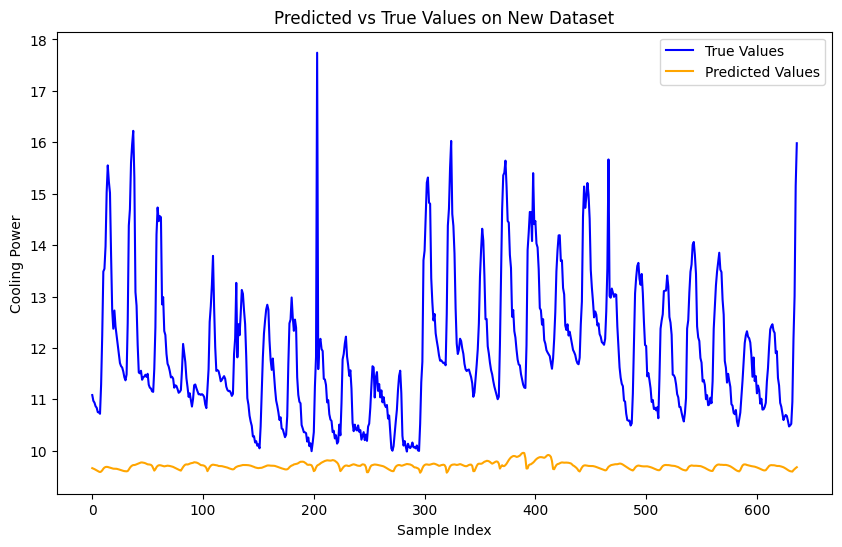

Mean Squared Error (MSE): 6.657054160408903
Mean Absolute Error (MAE): 2.221081237650681


In [290]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 예측값과 실제값 시각화
plt.figure(figsize=(10, 6))
plt.plot(new_y_true, label="True Values", color="blue")
plt.plot(new_y_pred, label="Predicted Values", color="orange")
plt.legend()
plt.title("Predicted vs True Values on New Dataset")
plt.xlabel("Sample Index")
plt.ylabel("Cooling Power")
plt.show()

# 성능 평가
mse = mean_squared_error(new_y_true, new_y_pred)
mae = mean_absolute_error(new_y_true, new_y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
